In [1]:
from collections.abc import Callable # For creating type hint for decorator function
from dotenv import load_dotenv # For getting .env params
import typing as tp # For creating type hints for functions
import networkx as nx # For visualising ego graph
import os # For getting .env params
import functools # For correct showing docstring of decorated function
import requests # For sending requests to API
import time # For making delay between API calls
import json # For formatting response data

In [2]:
load_dotenv()
class APIValues():
    """Class which stores important api constants"""
    TOKEN = os.getenv("VK_TOKEN")
    VERSION = os.getenv("API_VERSION")
    # 235379111 219352292 534920918
    USER = '235379111'

In [3]:
def api_response_cacher(func: Callable) -> Callable:
    """Decorator for caching api requests responses"""
    
    @functools.wraps(func)
    def wrapped(*args):
        response_data = wrapped.previous_request.get(args, None)
        if not response_data is None:
            print('Request with args={} was already made'.format(*args))
            return response_data
        
        result = func(*args)
        wrapped.previous_request[*args] = result
        return result
    
    wrapped.previous_request = {}
    return wrapped

### Получение id и имён всех друзей пользователя

In [4]:
@api_response_cacher
def get_friends(user_id: str, token: str, version: str, fields: str) -> dict[str, tp.Any]:
    """
    
    Gets information about user friends by makin vk API request
    
    Args:
        user_id (str): vk id of a user
        token (str): token for accessing vk api
        version (str): used api version
        fields (str): additional params
    
    Returns:
        Dictionary with info about user friends
     
    Raises:
        requests.exceptions.HTTPError: problem with sendning request
        SystemExit: Unknown exception
        
    """
    request_url = 'https://api.vk.com/method/friends.get'
    params = {
        'user_id' : user_id,
        'v' : APIValues.VERSION,
        'access_token' : APIValues.TOKEN,
        'fields' : fields
    }
    try:
        response = requests.get(request_url, params=params)
        response.raise_for_status()
        request_json = json.loads(response.text) 
    except requests.exceptions.HTTPError as exc:
        raise requests.exceptions.HTTPError(exc)
    except Exception as exc:
        raise SystemExit(exc)

    return request_json

In [5]:
friends_info = get_friends(APIValues.USER, 
                           APIValues.TOKEN, 
                           APIValues.VERSION, 
                           'first_name,last_name')
friends_info

{'response': {'count': 33,
  'items': [{'id': 164513048,
    'track_code': '3823f56fvkT7afVxj4qxL5eHdAY3lSzv2TQ_f6fz3WnBUf5EhK3TL6kLmnmA3bUupB266oz5X_vAOCgRw4CC',
    'first_name': 'Ильяс',
    'last_name': 'Акбергенов',
    'can_access_closed': True,
    'is_closed': False},
   {'id': 189063395,
    'track_code': '7022a9faF_a-q9Z7auJUrY8_48B7v5gVunjBKdVR8dngwCGpt5R6nbadvHpguQWsvaYgIcDT6wGjdNZHsSKu',
    'first_name': 'Светлана',
    'last_name': 'Кокожанова',
    'can_access_closed': True,
    'is_closed': False},
   {'id': 195449283,
    'track_code': '85c623038C6ZTE_zN0mE8xgxlGr6DjJpkIpjsZ2N4opMK3603ZudRZN7JaFqHob3I6lWjUFiQX2JhnTf-f69',
    'first_name': 'Анастасия',
    'last_name': 'Попова',
    'can_access_closed': True,
    'is_closed': False},
   {'id': 202110654,
    'track_code': '2243602dw5ITww4mfSM6RnBjM6l4Hn-abNW7USOV--yMuAjeILuu-R7yYXF6ITlPQ__8ScNyDI512aw_R-ak',
    'first_name': 'Alina',
    'last_name': 'Fedorova',
    'can_access_closed': True,
    'is_closed': False},

In [6]:
def filter_users(friends_json: dict[str, tp.Any]) -> dict[str, str]:
    """Extracts users that could be analyzed by getMutual request"""
    try:
        '''
        Deactivated users and users with private page 
        will cause request error, so we remove them
        '''
        #old dict format - i_friend['id'] : f"{i_friend['first_name']} {i_friend['last_name']}"
        friends_id_list = {i_friend['id'] : i_friend['first_name']
                           for i_friend in friends_json['response']['items']
                           if i_friend.get('deactivated', 0) == 0 and i_friend['is_closed'] == False}
    except ValueError as exc:
        raise ValueError('Incorrect json format, error info:', str(exc))
    except Exception as exc:
        raise SystemExit('Uknown exception', exc)

    return friends_id_list
    

In [7]:
friends_list = filter_users(friends_info)
friends_list

{164513048: 'Ильяс',
 189063395: 'Светлана',
 195449283: 'Анастасия',
 202110654: 'Alina',
 238082294: 'Санжар',
 242728221: 'Салтанат',
 258661653: 'Артур',
 268661244: 'Данил',
 276298118: 'Иван',
 281376995: 'Дина',
 281541945: 'Александр',
 294637251: 'Андрей',
 296352075: 'Эдуард',
 299099053: 'Karina',
 329080025: 'Алексей',
 336051333: 'Rezi',
 343660463: 'Алиса',
 364644536: 'Темир',
 448950839: 'Амирторе',
 449514319: 'Дмитрий',
 451431710: 'Анцель',
 478100920: 'Герман',
 491107885: 'Vladislav',
 534920918: 'Алексей',
 538775046: 'Artyr',
 593095818: 'Amir',
 604542761: 'Aslan',
 640860154: 'Артур',
 698955220: 'Денис',
 809506907: 'Майра'}

### Вычисление связей между узлами графа

In [8]:
def group_list(input_list: list[tp.Any], group_size: int) -> list[list[tp.Any]]:
    """
    
    Transforms input 1-D list into 2-D, 
    which consists from sublists with fixed size.

    Args:
        input_list (list[tp.Any]): 1-D list for transformation
        group_size (int): size of sublists

    Returns:
        list[list[]], filled with groups of initial list elements

    Examples:
        group_list([1, 2, 3, 4, 5], 2)
        >> [[1, 2], [3, 4], [5]]
        
    """
    result_list = []
    
    if len(input_list) <= group_size:
        return [input_list]
    else:
        result_list.append(input_list[0:group_size])
        result_list.extend(group_list(input_list[group_size:], group_size))

    return result_list    

In [9]:
def form_edges(node: int, 
                    connected_nodes: list[int],
                    used_ids: list[int]
                   ) -> list[tuple[int, int]]:
    
    """Forms edges from current node and its connected nodes"""
    graph_edges = []
    for i_node in connected_nodes:
        if not i_node in used_ids:
            graph_edges.append((node, i_node))
    return graph_edges

In [10]:
def get_friends_connections(response_json: dict[str, tp.Any], 
                            used_ids: list[int]
                           ) -> (list[tuple[int, int]], list[int]):
    """
    
    Creates friends connection list from vk api getMutual response data
    
    Args:
        response_json (dict[str, tp.Any]): vk api getMutual response
        used_ids (list[int]): id of users with already found connections
    
    Returns:
        list[tuple[int, int]], list of connections for every friend from response
        list[int], updated used_ids list
    
    """
    graph_edges = []
    for i_common_friends in response_json["response"]:
        if i_common_friends["common_count"] > 0:
            used_ids.append(i_common_friends["id"])
            user_edges = form_edges(i_common_friends["id"], 
                                         i_common_friends['common_friends'],
                                         used_ids)
            graph_edges.extend(user_edges)
    
    return graph_edges, used_ids

In [11]:
def ego_network(token: str,
                version: str,
                user_id: tp.Optional[int] = None, 
                friends: tp.Optional[list[int]] = None
               ) -> list[tuple[int, int]]:
    """
    
    Builds egocentrical graph for friends of given user
    
    Args:
        token (str): token for accessing vk api
        version (str): used api version
        user_id (tp.Optional[int]): id of person for whom we are creating graph
        friends (tp.Optional[list[int]]): list of nodes for which we will create connections 
    
    Returns: 
        list[tuple[int, int]], list of egocentrical graph edges
    
    Raises:
        requests.exceptions.HTTPError: problem with sendning request
        ValueError: problem with response
        SystemExit: Unknown exception
    
    """
    if not user_id:
        user_id = APIValues.USER
    
    if not friends:
        friends_json = get_friends(user_id, 
                                   APIValues.TOKEN, 
                                   APIValues.VERSION, 
                                   'first_name,last_name')
        friends = filter_users(friends_json)
    
    graph_edges = []
    used_ids = []
    
    request_url = 'https://api.vk.com/method/friends.getMutual'

    # Groupping friends by 100s to not exceed getMutual limits
    groupped_friends = group_list(friends, 100)
    
    for friend_list in groupped_friends:
        time.sleep(0.36)
        friends_id_line = ','.join(map(str, friend_list))
        
        params = {
            'access_token' : token,
            'v' : version,
            'source_uid' : str(user_id),
            'target_uids': friends_id_line
        }
        
        try:
            response = requests.get(request_url, params=params)
            response.raise_for_status()
            response_json = json.loads(response.text)
            group_edges, used_ids = get_friends_connections(response_json, 
                                                            used_ids)
            graph_edges.extend(group_edges)
                    
        except requests.exceptions.HTTPError as exc:
            raise requests.exceptions.HTTPError(exc)
        except ValueError as exc:
            raise ValueError('Incorrect json format, error info:', str(exc))
        except Exception as exc:
            raise SystemExit('Unknown exception', str(exc))
            
    return graph_edges
           

In [12]:
graph_edges = ego_network(APIValues.TOKEN, APIValues.VERSION)

Request with args=235379111 was already made


In [13]:
graph_edges

[(164513048, 242728221),
 (164513048, 364644536),
 (189063395, 809506907),
 (195449283, 202110654),
 (195449283, 281376995),
 (195449283, 296352075),
 (195449283, 299099053),
 (195449283, 347116644),
 (195449283, 581699606),
 (202110654, 281376995),
 (202110654, 296352075),
 (202110654, 299099053),
 (202110654, 581699606),
 (238082294, 364644536),
 (258661653, 268661244),
 (258661653, 491107885),
 (268661244, 491107885),
 (276298118, 281541945),
 (276298118, 478100920),
 (281376995, 299099053),
 (281376995, 581699606),
 (281541945, 294637251),
 (281541945, 451431710),
 (281541945, 478100920),
 (281541945, 604542761),
 (294637251, 451431710),
 (294637251, 604542761),
 (296352075, 581699606),
 (329080025, 448950839),
 (329080025, 538775046),
 (329080025, 593095818),
 (329080025, 640860154),
 (364644536, 809506907),
 (448950839, 593095818),
 (448950839, 640860154),
 (478100920, 698955220)]

### Визуализация эгоцентричного графа

In [14]:
def draw_graph(nodes: list[int], 
               edges: list[tuple[int, int]], 
               labels: dict[int, str]) -> None:
    """Drawing result graph by networkx library"""
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, edge_color='black')

    nx.draw(G, pos, labels=labels, node_size=50,  width=0.2)
    

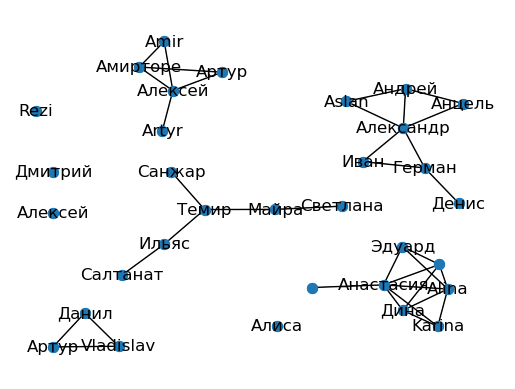

In [15]:
draw_graph(friends_list.keys(), graph_edges, friends_list)

### (ТЕСТЫ) Построение графа общих друзей

In [16]:
# OLD test code
def get_potential_friends_edges(friends_ids: list[str]) -> list[tuple[int]]:
    graph_edges = []
    request_url = 'https://api.vk.com/method/friends.getMutual'
    for i_friend in friends_ids[:]:
        time.sleep(0.36)
        friends_ids.remove(i_friend)
        if len(friends_ids) == 0:
            break
        line_with_friends_id = ','.join(friends_ids)
        params = {
            'v' : APIValues.VERSION,
            'access_token' : APIValues.TOKEN,
            'source_uid' : i_friend,
            'target_uids': line_with_friends_id
        }
        try:
            response = requests.get(request_url, params=params)
            response.raise_for_status()
            response_json = json.loads(response.text)
            for i_common_friends_info in response_json["response"]:
                if i_common_friends_info["common_count"] > 1:
                    connected_friend = i_common_friends_info["id"]
                    graph_edges.append((int(i_friend), connected_friend))
        
        except requests.exceptions.HTTPError as exc:
            raise requests.exceptions.HTTPError(exc)
        except ValueError as exc:
            raise ValueError('Incorrect json format, error info:', str(exc))
        except Exception as exc:
            raise SystemExit('Unknown exception', str(exc))
        
    return graph_edges

In [17]:
potential_friends_edges = get_potential_friends_edges(list(map(str, friends_list)))

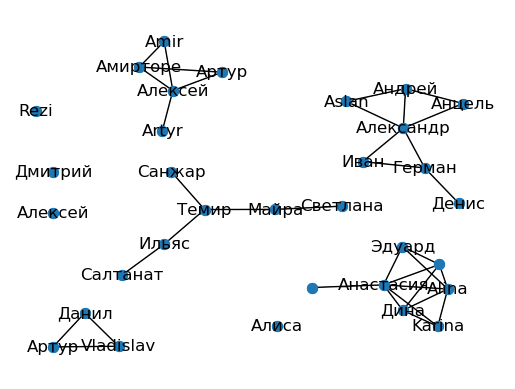

In [18]:
draw_graph(friends_list.keys(), graph_edges, friends_list)

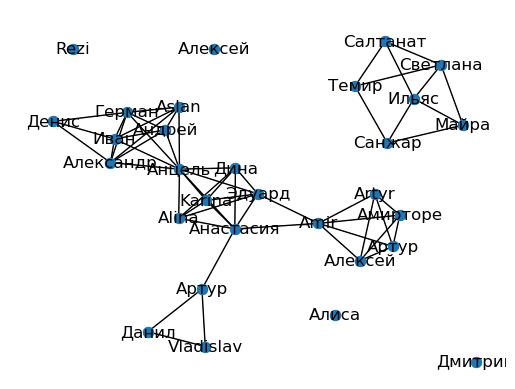

In [19]:
draw_graph(friends_list.keys(), potential_friends_edges, friends_list)